In [ ]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
from PIL import Image
from IPython.display import display
import torchvision.transforms.functional as F


import sys
from elasticdino.model.elasticdino import ElasticDino

def get_edino():
    edino = ElasticDino.from_pretrained("path/to/checkpoint", "elasticdino-32-L", dino_repo="??")
    edino.eval()
    edino.requires_grad_ = False
    return edino

edino = get_edino().cuda()
# edino = torch.compile(get_edino().cuda())

from transformers import SiglipProcessor, AutoModel


siglip = AutoModel.from_pretrained("google/siglip-base-patch16-224").cuda()
siglip_processor = SiglipProcessor.from_pretrained("google/siglip-base-patch16-224")

sys.path.append("path/to/PhraseCutDataset")
from utils.refvg_loader import RefVGLoader
from utils.file_paths import img_fpath
refvg_loader = RefVGLoader(split='train')

from concurrent.futures import ThreadPoolExecutor

import os

def check_file(i):
    p = os.path.join(img_fpath, f'{i}.jpg')
    if os.path.isfile(p):
        return i
    else:
        return None

with ThreadPoolExecutor(64) as executor:
    results = list(executor.map(check_file, refvg_loader.img_ids))

valid_ids = [i for i in results if i is not None]

In [2]:
import os 
import skimage
import random

IMAGE_SIZE = 128

def get_biggest_polygon(polygons, h, w):
    l = min(h, w)
    biggest = -1
    index = 0
    selected = None
    for i in range(len(polygons)):
        mask = None
        for plist in polygons[i]:
            for p in plist:
                p = [[x, y] for y, x in p]
                m = skimage.draw.polygon2mask([h, w],p)[:l, :l]
                if mask is None:
                    mask = m
                else:
                    mask = mask | m
        area = np.sum(mask)

        choose = True if selected is None else random.random() < 0.5
        if area > biggest and choose:
            biggest = area
            index = i
            selected = mask
    return selected, index
            
            
def get_random_polygon(polygons, h, w):
    l = min(h, w)
    i = random.randint(0, len(polygons) - 1)
    mask = None
    for plist in polygons[i]:
        for p in plist:
            p = [[x, y] for y, x in p]
            m = skimage.draw.polygon2mask([h, w],p)[:l, :l]
            if mask is None:
                mask = m
            else:
                mask = mask | m
    return mask, i
    
def to_samples(image_id):
    img = Image.open(os.path.join(img_fpath, '%d.jpg' % image_id)).convert("RGB")
    l = min(img.height, img.width)
    metadata = refvg_loader.get_img_ref_data(image_id)
    image = torchvision.transforms.functional.pil_to_tensor(img.crop((0, 0, l, l))).unsqueeze(0)/255.0
    
    
    mask, i = get_random_polygon(metadata["gt_Polygons"], img.height, img.width)
    phrase = metadata["phrases"][i]
    
    mask = mask[:l, :l]
    mask = torch.tensor(mask)
    image = torch.nn.functional.interpolate(image, IMAGE_SIZE)
    mask = torch.nn.functional.interpolate(mask.unsqueeze(0).unsqueeze(0).to(dtype=torch.float16), IMAGE_SIZE, mode="nearest").to(dtype=torch.long)
    return image.squeeze(), mask.squeeze(), phrase


class PhraseDataset(torch.utils.data.Dataset):
    def __init__(self):
        self.img_ids = valid_ids

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        return to_samples(self.img_ids[idx])

In [3]:


class ResidualFC(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(n_features, n_features),
            nn.BatchNorm1d(n_features),
            nn.GELU(),
            nn.Linear(n_features, n_features),
            nn.BatchNorm1d(n_features),
            nn.GELU(),
        )

    def forward(self, x):
        return x + self.layers(x)

class FC(nn.Module):
    def __init__(self, fin, out):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(fin, out),
            nn.ReLU(True),
        )

    def forward(self, x):
        return self.layers(x)


class CrossBlock(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.k = nn.Conv2d(n_features, n_features, 1)
        self.q = nn.Linear(n_features, n_features)
        self.v = nn.Conv2d(n_features, n_features, 1)
        self.mlp = nn.Sequential(nn.Conv2d(n_features,n_features, 1), nn.LeakyReLU(), nn.Conv2d(n_features,n_features, 1), nn.LeakyReLU(), nn.Conv2d(n_features,n_features, 1))
        self.n1 = nn.BatchNorm2d(n_features)
        self.n2 = nn.BatchNorm2d(n_features)

    def forward(self, x, y):
        k = self.k(x) # b x f x h x w
        q = self.q(y) # b x f
        v = self.v(x)  # b x f x h x w
        att = torch.sigmoid(torch.einsum("bfhw,bf->bhw", k, q)).unsqueeze(1)
        del q
        del k
        att = v * att
        del v
        att = self.n1(att) + x
        del x
        return self.n2(self.mlp(att)) + att
        
def get_image_features(images):
    inputs = siglip_processor(images=images, padding="max_length", return_tensors="pt")
    for k in inputs:
        inputs[k] = inputs[k].cuda()
    return siglip.get_image_features(**inputs)       

In [4]:


def sample_image_points(edino_features, mask, proportion):
    B, F, H, W = edino_features.shape
    n_samples = int(proportion * H * W)
    edino_features = edino_features.reshape((B, F, -1))
    mask = mask.reshape((B, 1, -1))

    indices = torch.stack([torch.randperm(H * W)[:n_samples] for _ in range(B)], dim=0).to("cuda")
    indices_expanded = indices.unsqueeze(1).expand(B, F, n_samples)
  
    edino_features = torch.gather(edino_features, dim=2, index=indices.unsqueeze(1).expand(B, F, n_samples)).transpose(1, 2) # don't reshape yet
    mask = torch.gather(mask, dim=2, index=indices.unsqueeze(1))
    mask = mask.flatten()
    
    return edino_features, mask
       

class CrossModel(nn.Module):
    def __init__(self, n_features=1024):
        super().__init__()
        self.image_project = nn.Conv2d(1024, n_features, 1)
        self.text_project = nn.Linear(768, n_features)
        self.layers = nn.ModuleList([CrossBlock(n_features) for _ in range(6)])
        self.out = nn.Sequential(
            nn.Conv2d(n_features, n_features // 4, 1),
            nn.LeakyReLU(),
            nn.Conv2d(n_features // 4, n_features // 16, 1),
            nn.LeakyReLU(),
            nn.Conv2d(n_features // 16, 1, 1),
        )

    def forward(self, image_features, text_features):
        image_features = self.image_project(image_features)
        text_features = self.text_project(text_features)
        for l in self.layers:
            image_features = l(image_features, text_features)
        return self.out(image_features)

class ResidualBlockConv(nn.Module):
    def __init__(self, n_features=1024): 
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(n_features,n_features,1, bias=False),
            nn.BatchNorm2d(n_features),
            nn.GELU(),
            nn.Conv2d(n_features,n_features,1, bias=False),
            nn.BatchNorm2d(n_features),
            nn.GELU(),
        )
    def forward(self, x):
        return x + self.layers(x)

class EncoderModel(nn.Module):
    def __init__(self, n_features=2048, temperature = 0.2):
        super().__init__()
        self.temperature = temperature

        self.text_encoder = nn.Sequential(
            nn.Linear(768, n_features),
            nn.BatchNorm1d(n_features),
            ResidualFC(n_features),
            ResidualFC(n_features),
            ResidualFC(n_features),
            # ResidualFC(n_features),
            # ResidualFC(n_features),
            # ResidualFC(n_features),
            # FC(n_features, n_features // 4),
            # FC(n_features // 4, n_features // 16),
            nn.Linear(n_features, 1024),
        )

    def forward(self, image_features, text_features):
        text_features = torch.nn.functional.normalize(self.text_encoder(text_features), dim=1)
        return torch.einsum("bchw,bc->bhw", image_features, text_features) / self.temperature
        
@torch.no_grad
def make_saliency_map_flat(model, image, text, mask=None):
    C, H, W = image.shape
    features = edino(image.unsqueeze(0))
    objects_features = siglip.get_text_features(siglip_processor(text=[text])["input_ids"].cuda())
    res = torch.sigmoid(model(features, objects_features))
    print(text)
    salience = F.to_pil_image(res[0]).resize((128, 128)).convert("RGB")
    image = F.to_pil_image(image).resize((128, 128))
    x = [image, salience]
    if mask is not None:
        x.append(F.to_pil_image(mask.to(dtype=torch.float32)).resize((128, 128)).convert("RGB"))
    display(Image.fromarray(np.hstack(x)))
    
class BinaryDiceLoss(nn.Module):
    def __init__(self, smooth=1.0, p=2, reduction='mean'):
        super().__init__()
        self.smooth = smooth
        self.p = p
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Flatten tensors
        inputs = torch.sigmoid(inputs.contiguous().view(inputs.shape[0], -1))
        targets = targets.contiguous().view(targets.shape[0], -1)

        # Numerator and denominator of Dice coefficient
        num = (2 * (inputs * targets).sum(dim=1)) + self.smooth
        den = (inputs.pow(self.p).sum(dim=1) + targets.pow(self.p).sum(dim=1)) + self.smooth

        dice_score = num / den
        loss = 1 - dice_score

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss
        
def train_cross(debug_interval=50, batch_size=32, max_iterations=None):
    n = 0
    model = EncoderModel().cuda()
    # model = torch.compile(model)
    import bitsandbytes
    
    optimizer = bitsandbytes.optim.AdamW8bit(
        [{"params": model.parameters(), "lr": 1e-4}], eps=1e-5, weight_decay=1e-4)
    scaler = torch.amp.GradScaler()
    running_loss = None
    for epoch in range(10):
        print("Epoch", epoch + 1)
        for images, mask, phrases in torch.utils.data.DataLoader(PhraseDataset(), batch_size=batch_size, shuffle=True):
            images = images.cuda()
            mask = mask.cuda()
            n+=1
            if max_iterations is not None and n > max_iterations:
                return
            with torch.no_grad():
                embeds = siglip.get_text_features(siglip_processor(text=phrases, padding=True,)["input_ids"].cuda()).squeeze()
            with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
                with torch.no_grad():
                    features = edino(images)
                predicted = model(features, embeds)
                loss = BinaryDiceLoss()(predicted.reshape((-1, 1)), mask.to(dtype=torch.float32).reshape((-1, 1))) + nn.BCEWithLogitsLoss()(predicted.reshape((-1, 1)), mask.to(dtype=torch.float32).reshape((-1, 1)))
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
    
            optimizer.zero_grad()
            if running_loss is None:
              running_loss = loss.detach()
            else:
              running_loss = 0.98 * running_loss + 0.02 * loss.detach()  
            if n == 1:
                print("First iteration done")
            if n % debug_interval == 0:
                model.eval()
                print(n, running_loss.item())
                make_saliency_map_flat(model, F.pil_to_tensor(Image.open("dog.jpeg").convert("RGB").resize((128, 128))).cuda() / 255.0, "grass")
                make_saliency_map_flat(model, F.pil_to_tensor(Image.open("dog.jpeg").convert("RGB").resize((128, 128))).cuda() / 255.0, "dog")
                make_saliency_map_flat(model, F.pil_to_tensor(Image.open("person.jpeg").convert("RGB").resize((128, 128))).cuda() / 255.0, "hair")
                make_saliency_map_flat(model, F.pil_to_tensor(Image.open("person.jpeg").convert("RGB").resize((128, 128))).cuda() / 255.0, "shirt")
                make_saliency_map_flat(model, F.pil_to_tensor(Image.open("car.jpeg").convert("RGB").resize((128, 128))).cuda() / 255.0, "window")
                make_saliency_map_flat(model, F.pil_to_tensor(Image.open("car.jpeg").convert("RGB").resize((128, 128))).cuda() / 255.0, "car")
                make_saliency_map_flat(model, images[0], phrases[0], mask[0])
                model.train()
            
            
            del images
            del features
            del mask
            del embeds
            del predicted
            del loss
            
# train_cross(debug_interval=100)

In [ ]:
from safetensors import safe_open

tensors = {}


class EncoderModel(nn.Module):
    def __init__(self, n_features=2048, temperature = 0.2):
        super().__init__()

        self.temperature = temperature

        self.text_encoder = nn.Sequential(
            nn.Linear(768, n_features),
            nn.BatchNorm1d(n_features),
            ResidualFC(n_features),
            ResidualFC(n_features),
            ResidualFC(n_features),
            ResidualFC(n_features),
            ResidualFC(n_features),
            nn.Linear(n_features, 1024),
        )

    def forward(self, image_features, text_features):
        text_features = torch.nn.functional.normalize(self.text_encoder(text_features), dim=1)
        return torch.einsum("bchw,bc->bhw", image_features, text_features) / self.temperature

model = EncoderModel()

with safe_open("path/to/trained/checkpoint", framework="pt", device=0) as f:
    f = {x: f.get_tensor(x) for x in f.keys()}
    model.load_state_dict(f)
model = model.cuda()
model.eval()

In [6]:
segmentation_palette = [
    "#1f77b4",  # muted blue
    "#ff7f0e",  # orange
    "#2ca02c",  # green
    "#d62728",  # red
    "#9467bd",  # purple
    "#8c564b",  # brown
    "#e377c2",  # pink]
]

from PIL import Image, ImageDraw, ImageFont

def create_color_legend(colors, labels, H=128, swatch_width=10, padding=10, font_size=13):
    assert len(colors) == len(labels)
    n = len(colors)
    row_height = H // n
    width = swatch_width + 3 * padding + max([len(label) for label in labels]) * font_size // 2

    img = Image.new("RGB", (width, H), "white")
    draw = ImageDraw.Draw(img)

    try:
        font = ImageFont.truetype("DejaVuSans.ttf", font_size)
    except IOError:
        font = ImageFont.load_default()

    for i, (color, label) in enumerate(zip(colors, labels)):
        y = i * row_height
        draw.rectangle([padding, y + padding, padding + swatch_width, y + row_height - padding], fill=color)
        draw.text((2 * padding + swatch_width, y + row_height // 2 - font_size // 2), label, fill="black", font=font)

    return img


def hex_to_rgb(hex_str: str) -> tuple:
    h = hex_str.lstrip('#')
    return tuple(int(h[i:i+2], 16) for i in (0, 2, 4))

def overlay_masks(
    image: torch.Tensor,           # shape (3, H, W), values 0–1 or 0–255
    masks: torch.Tensor,           # shape (N, H, W), values 0 or 1 (or in [0,1])
    colors: list[str],             # length N, hex strings like "#ff0000"
    alpha: float = 0.5             # blending factor
) -> Image.Image:
    """
    Returns a PIL Image with masks overlaid on the image.
    Masks are applied in order; later masks blend on top of earlier ones.
    """
    # convert image to numpy HxWx3 uint8
    if image.max() <= 1.0:
        img_np = (image.mul(255)).byte().cpu().numpy()
    else:
        img_np = image.byte().cpu().numpy()
    img_np = np.transpose(img_np, (1, 2, 0))  # H, W, C

    overlay = img_np.copy().astype(np.float32)
    H, W, _ = overlay.shape

    # for each mask
    for i in range(masks.shape[0]):
        mask = masks[i].cpu().numpy()
        if mask.ndim == 2:
            mask = mask[..., None]  # H, W, 1
        color = np.array(hex_to_rgb(colors[i]), dtype=np.float32)[None, None, :]  # 1,1,3

        # ensure mask is in [0,1]
        mask = np.clip(mask, 0, 1).astype(np.float32)

        # blend: overlay = overlay * (1 - alpha*mask) + color * (alpha*mask)
        overlay = overlay * (1 - alpha * mask) + color * (alpha * mask)

    overlay = np.clip(overlay, 0, 255).astype(np.uint8)
    return Image.fromarray(overlay)


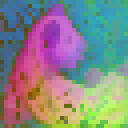

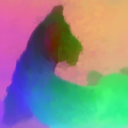

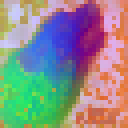

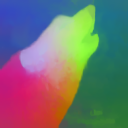

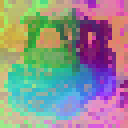

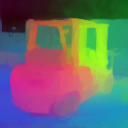

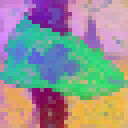

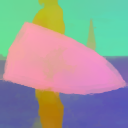

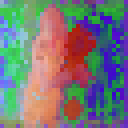

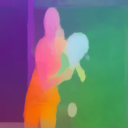

In [43]:
import os
from elasticdino.training.util import debug_features
for x in os.listdir(".."):
    if x.startswith("Screenshot"):
        image = Image.open(f"../{x}").resize((256, 256)).convert("RGB")
        image = torchvision.transforms.functional.pil_to_tensor(image).unsqueeze(0).cuda() / 255.0
        features = edino(image, return_original_features=True)
        display(debug_features(features["original_features"].squeeze(), [])     )   
        display(debug_features(features["deformed_features"].squeeze(), [])     )   
        
                           
        # edino.dino
        

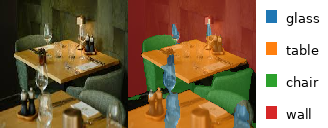

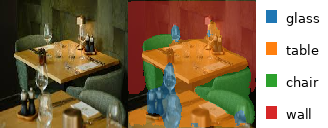

In [25]:

# Load image
from PIL import Image

target_image = Image.open("restaurant.jpeg")
prompts = ["glass", "table", "chair", "wall"]

def make_logits(model, image, labels):
    logits = []
    for text in labels:
        features = edino(image.unsqueeze(0))
        objects_features = siglip.get_text_features(siglip_processor(text=[text])["input_ids"].cuda())
        logits.append(model(features, objects_features))
        del features
        del objects_features
    return torch.stack(logits, dim=1)
    
@torch.no_grad()
def make_segmentation(model, image, labels, mask=None):
    C, H, W = image.shape
    logits = []
    for text in labels:
        features = edino(image.unsqueeze(0))
        objects_features = siglip.get_text_features(siglip_processor(text=[text])["input_ids"].cuda())
        logits.append(model(features, objects_features))
        del features
        del objects_features
    logits = torch.stack(logits, dim=1)
    masks = logits.squeeze() > 0
    # res = torchvision.utils.draw_segmentation_masks(image, masks.squeeze(0), alpha=0.3, colors=segmentation_palette)
    salience = overlay_masks(image.squeeze(), masks, segmentation_palette[:len(labels)])
    image = F.to_pil_image(image).resize((128, 128))
    legend = create_color_legend(segmentation_palette[:len(labels)], labels)
    x = [image, salience, legend]
    if mask is not None:
        x.append(F.to_pil_image(mask.to(dtype=torch.float32)).resize((128, 128)).convert("RGB"))
    display(Image.fromarray(np.hstack(x)))





# Load model and processor
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation

clipsegprocessor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined", local_files_only=True)
clipseg = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined", local_files_only=True).cuda()

# Prepare inputs
inputs = clipsegprocessor(text=prompts, images=[target_image] * len(prompts), padding="max_length", return_tensors="pt")

# Run model
import torch

with torch.no_grad():
    # print(inputs)
    inputs = {x: inputs[x].cuda() for x in inputs}
    logits = clipseg(**inputs).logits



@torch.no_grad()
def make_segmentation2(logits, image, labels, mask=None):
    image = torchvision.transforms.functional.pil_to_tensor(image).unsqueeze(0).cuda() / 255.0
    image = nn.functional.interpolate(image, 128)
    logits = nn.functional.interpolate(logits.unsqueeze(0), 128)
    masks = logits.squeeze() > 0
    # res = torchvision.utils.draw_segmentation_masks(image, masks.squeeze(0), alpha=0.3, colors=segmentation_palette)
    salience = overlay_masks(image.squeeze(), masks, segmentation_palette[:len(labels)])
    image = F.to_pil_image(image.squeeze()).resize((128, 128))
    legend = create_color_legend(segmentation_palette[:len(labels)], labels)
    x = [image, salience, legend]
    if mask is not None:
        x.append(F.to_pil_image(mask.to(dtype=torch.float32)).resize((128, 128)).convert("RGB"))
    display(Image.fromarray(np.hstack(x)))


@torch.no_grad()
def make_segmentation3(logits, image, labels, mask=None):
    logits = logits.squeeze()
    image = torchvision.transforms.functional.pil_to_tensor(image).unsqueeze(0).cuda() / 255.0
    image = nn.functional.interpolate(image, 128)
    logits = nn.functional.interpolate(logits.unsqueeze(0), 128)
    logits = logits.squeeze()
    bg = logits.max(dim=0, keepdim=True)[0] < -1
    
    segmentation_mask = torch.argmax(logits, dim=0)
    segmentation_mask_onehot = torch.nn.functional.one_hot(segmentation_mask, num_classes=len(labels)).permute(2, 0, 1).to(torch.bool)
    segmentation_mask_onehot = segmentation_mask_onehot & (~bg)
    masks= segmentation_mask_onehot
    # masks = torch.cat([segmentation_mask_onehot, bg], dim=0)
    salience = overlay_masks(image.squeeze(), masks,  segmentation_palette[:len(labels)] )
    image = F.to_pil_image(image.squeeze()).resize((128, 128))
    legend = create_color_legend(segmentation_palette[:len(labels)], labels)
    x = [image, salience, legend]
    if mask is not None:
        x.append(F.to_pil_image(mask.to(dtype=torch.float32)).resize((128, 128)).convert("RGB"))
    display(Image.fromarray(np.hstack(x)))

imgtensor = F.pil_to_tensor(target_image.convert("RGB").resize((128, 128))).cuda() / 255.0
my_logits = make_logits(model, imgtensor, prompts)
make_segmentation3(my_logits, target_image, prompts )

make_segmentation3(logits, target_image, prompts)